In [1]:
from config import *
from model import VNTrOCR, AdapterVNTrOCR
from utils import infer
import torch
from transformers import AutoTokenizer, TrOCRProcessor
from PIL import Image
import numpy as np
from torch.nn import functional as F

/mnt/disk1/anaconda3/envs/anhnh/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device="cuda:2"
# model = VNTrOCR()
# model.load_state_dict(torch.load("/mnt/disk4/VN_HTR/VN_HTR/VisionEncoderDecoder/weights/cp_finetune_v2_5.pt", map_location=device))
model = AdapterVNTrOCR(config)
model.load_state_dict(torch.load("/mnt/disk4/VN_HTR/VN_HTR/VisionEncoderDecoder/weights/cp_add_finetune_v2.pt", map_location=device))
tokenizer = AutoTokenizer.from_pretrained("vinai/bartpho-syllable-base")
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-handwritten")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/mnt/disk1/anaconda3/envs/anhnh/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [3]:
def infer_topk(pixel_values, net, max_seq_length=35, sos_token=0, eos_token=2, adapter=False):
    "data: BxCXHxW"
    net.eval()
    device = pixel_values.device
    net.to(device)
    if not adapter:
        model = net
    else:
        model = net.basemodel

    with torch.no_grad():
        encoder_output = model.forward_encode(pixel_values)
    
        start_ids = torch.LongTensor([[sos_token]]*pixel_values.shape[0]).to(device)

        max_length = 0

        probs = []
        tokens = []

        while max_length <= max_seq_length and not all(start_ids[:, -1] == eos_token):
            output = model.forward_decode(start_ids, encoder_output)
            if adapter:
                output = net.forward_adapt(output)
            output = F.softmax(output[:,-1,:], dim=-1)

            start_ids = torch.cat([start_ids, output.argmax(dim=-1).unsqueeze(1)], dim=-1)

            _prob, _token = output.topk(k=5, dim=-1)
            # print(_prob.shape)
            probs.append(_prob[0].cpu().numpy())
            tokens.append(_token[0].cpu().numpy())

            max_length += 1
    
    return start_ids, np.array(tokens), np.array(probs)

In [ ]:
import os
x = []
for fn in os.listdir("/mnt/disk4/VN_HTR/VN_HTR/test"):
    img = Image.open("/mnt/disk4/VN_HTR/VN_HTR/test/" + fn)
    display(img)
    preds, tokens, probs = infer_topk(processor(img, return_tensors="pt").pixel_values, model, 50, adapter=True)
    print(tokenizer.batch_decode(preds, skip_special_tokens=True)[0], end=f"    ---{fn}---")
    x.append({"content": tokenizer.batch_decode(preds, skip_special_tokens=True)[0], "fn": fn})

In [ ]:
# test2_test2.jpg, wild_5_83.jpg, wild_26_86.jpg, wild_8_88.jpg

In [ ]:
img = Image.open("/mnt/disk4/VN_HTR/VN_HTR/test/test6_test1.jpg") #15,5
# img = Image.open("/mnt/disk4/VN_HTR/VN_HTR/WildLine/wild_5_83.jpg") #15,5
# img = Image.open("/mnt/disk4/VN_HTR/VN_HTR/WildLine/wild_26_86.jpg") #15,5
# img = Image.open("/mnt/disk4/VN_HTR/VN_HTR/WildLine/wild_8_88.jpg") #15,5
display(img)
preds, tokens, probs = infer_topk(processor(img, return_tensors="pt").pixel_values, model, 50, adapter=True)
print(tokenizer.batch_decode(preds, skip_special_tokens=True)[0])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, Normalize

weights = probs.T


# plt.figure(figsize = (64, 9))

fig, ax = plt.subplots(figsize=(15, 5))

# Create a custom colormap that transitions from white to 'viridis'
viridis_white = plt.cm.Blues(np.linspace(0, 1, 256))
viridis_white[:, :3] = 1 - (1 - viridis_white[:, :3]) * 0.7  # Adjust the brightness

# Create a LinearSegmentedColormap using the custom colormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', viridis_white)

# Set the normalization to map the weights to the range [0, 1]
norm = Normalize(vmin=0, vmax=1)

# Use the created colormap in imshow with the specified norm
cax = ax.imshow(weights, cmap=cmap, interpolation='none', norm=norm)

for i in range(tokens.shape[1]):
    text = tokenizer.batch_decode(tokens[:, i:i+1])
    print(text)
    for j in range(len(text)):
        char = text[j]
        if char == "<unk>": char = "#"
        if char == "<eos>": char = "/s"
        ax.text(j, i, char, ha='center', va='center')
# ax.text(0, 0, "h")
# ax.text(1, 0, "e")
# ax.text(2, 0, "l")
# ax.text(3, 0, "l")
# ax.text(4, 0, "o")
# ax.text(5, 0, " ")
# ax.text(6, 0, "w")

# Add colorbar to display the color scale
cbar = plt.colorbar(cax)

plt.show()

In [5]:
# adapter v2
for i in x:
    print(i)

{'content': 'theo nghị định số XH, 10, ngây b) - 136075', 'fn': 'test13_test1.jpg'}
{'content': 'nghệ có trụ sở tại Hà Nội, Việt Nam.', 'fn': 'test2_test2.jpg'}
{'content': 'công nghệ, tác động quan trọng và phát triển nền xanh', 'fn': 'test6_test1.jpg'}
{'content': 'chú hàng đầu Khu vực với nông cốt là kỹ thuật và', 'fn': 'test5_test1.jpg'}
{'content': 'Ký. Đây là trường Gọi học kỹ thuật đầu tiên của', 'fn': 'test15_test1.jpg'}
{'content': 'viên của hiệp hội các đại học kỹ thuật bằng đầu Khu', 'fn': 'test10_test1.jpg'}
{'content': 'lập vào ngày b khoáng 3 năm 2016. Ngày 5', 'fn': 'test9_test2.jpg'}
{'content': 'Hà Nội trở thành đại học đa thành viên thời La của XH', 'fn': 'test3_test1.jpg'}
{'content': 'GDP-to về việc chuyển Trường Đại học Bánh khoa Hà', 'fn': 'test1_test1.jpg'}
{'content': 'trong những đại học kỹ thuật lớn nhất vụ', 'fn': 'test4_test2.jpg'}
{'content': 'Việt Nam. Đại học Bách Khoa Hà Nội cũng là thành', 'fn': 'test9_test1.jpg'}
{'content': 'tế tivi thức và gốc phần g

In [5]:
import os
x = []
for fn in os.listdir("/mnt/disk4/VN_HTR/VN_HTR/test"):
    img = Image.open("/mnt/disk4/VN_HTR/VN_HTR/test/" + fn)
    # display(img)
    preds, tokens, probs = infer_topk(processor(img, return_tensors="pt").pixel_values, model, 50)
    print(tokenizer.batch_decode(preds, skip_special_tokens=True)[0], end=f"    ---{fn}---\n")
    x.append({"content": tokenizer.batch_decode(preds, skip_special_tokens=True)[0], "fn": fn})

theo nghị định số XH (TW ngày b) - 16/-2020 do    ---test13_test1.jpg---
nghệ có trụ sở tự Hà Nội, Việt Nam.    ---test2_test2.jpg---
công nghệ, tác động quan trọng vôi phát triển nền kinh    ---test6_test1.jpg---
cứu hàng đầu Khu vực với nông cốt là kỹ thật và    ---test5_test1.jpg---
Ký. Đây là trường. Đọc học kỹ thuật đầu tiên của    ---test15_test1.jpg---
viên của hiệp hội các đại học kỹ thuật hàng đầu Khu    ---test10_test1.jpg---
lập vào ngày có tháng 3 năm-2020. Ngày 5    ---test9_test2.jpg---
Hà Nội trở thành đại học đa thành viên thời lo của với    ---test3_test1.jpg---
XH về việc chuyển Trường Đại học Bách Khoa Hà    ---test1_test1.jpg---
trong những đại học kỹ thuật lớn nhất vụ,    ---test4_test2.jpg---
Việt Nam. Đại học Bách Khoa Hà Nội cùng là thành    ---test9_test1.jpg---
tế tai thức và gốp phần gắn giữa an ninh, trình    ---test7_test1.jpg---
là đại học theo lãnh việc xã thuật và công    ---test1_test2.jpg---
đất nước, tiêm phong trong hệ thống giáo dục đọc học    ---te

In [5]:
# adapter v2
x=[]
for i in range(100, 200):
    fn = testdf.iloc[i].filename
    if fn[:4] == "wild":
        img = Image.open("/mnt/disk4/VN_HTR/VN_HTR/WildLine/" + fn)
        preds, tokens, probs = infer_topk(processor(img, return_tensors="pt").pixel_values, model, 50, adapter=True)
        print(tokenizer.batch_decode(preds, skip_special_tokens=True)[0], end=f"    ---{fn}---\n")
        x.append({"content": tokenizer.batch_decode(preds, skip_special_tokens=True)[0], "fn": fn})

bôi mỏi "chót vót"    ---wild_4_163.jpg---
Khi dám    ---wild_28_188.jpg---
Lê Minh Khuê là một nhà văn nữ    ---wild_11_0.jpg---
Họ đứng trên n    ---wild_15_172.jpg---
Câu 2:    ---wild_0_1113.jpg---
nâng cao phúc lợi XH và    ---wild_32_121.jpg---
bắn cháy và    ---wild_36_677.jpg---
Khi nỗi mình bước xao nhân ông hôn có miền mang    ---wild_22_61.jpg---
Hình ảnh núi rừng    ---wild_2_125.jpg---
- Tốc độ tăng trưởng KT bình quan đạt 15-XH năm    ---wild_3_811.jpg---
học, công nghệ.    ---wild_1_783.jpg---
lực và động lực để phỉ    ---wild_30_1124.jpg---
nâng cao đời sống nhân dân    ---wild_44_121.jpg---
Các mạng vụ là một bộ phận khăng khít của cách mạng thế giới.    ---wild_10_83.jpg---
gieo bằng vẫn ở: "tạo âm điệu    ---wild_24_144.jpg---
Nội dung của Hội Nghị Trung ương Đảng Cộng    ---wild_1_12.jpg---
người    ---wild_47_1093.jpg---
tích tục đổi mắt với nhiều khó khăn mới, chia ta có quyền    ---wild_3_1122.jpg---
hồn tôi khi Tổ quốc soi vào    ---wild_10_144.jpg---
hiện thực 

In [4]:
import pandas as pd
testdf = pd.read_csv("/mnt/disk4/VN_HTR/VN_HTR/test_anot.csv")[-2000:]
# 18, 56, 69

In [10]:
# base
x=[]
for i in range(100,200):
    fn = testdf.iloc[i].filename
    if fn[:4] == "wild":
        img = Image.open("/mnt/disk4/VN_HTR/VN_HTR/WildLine/" + fn)
        preds, tokens, probs = infer_topk(processor(img, return_tensors="pt").pixel_values, model, 50, adapter=False)
        print(tokenizer.batch_decode(preds, skip_special_tokens=True)[0], end=f"    ---{fn}---\n")
        x.append({"content": tokenizer.batch_decode(preds, skip_special_tokens=True)[0], "fn": fn})

bởi mới "chót vót"    ---wild_4_163.jpg---
Khi dám    ---wild_28_188.jpg---
Lê Minh Khuê là một nhà văn nữ    ---wild_11_0.jpg---
Họ đứng trên n    ---wild_15_172.jpg---
Câu 2:    ---wild_0_1113.jpg---
nâng cao phúc lợi XH và    ---wild_32_121.jpg---
bàn cháy. Tạ    ---wild_36_677.jpg---
Khi nỗi mình bước Xạng nhân công hôm có miền mang    ---wild_22_61.jpg---
Hình ảnh núi rừng    ---wild_2_125.jpg---
- Tốc độ tăng trưởng KT bình quan đạt 15-XH năm    ---wild_3_811.jpg---
khoa học, công nghệ.    ---wild_1_783.jpg---
lực và động lực để ít    ---wild_30_1124.jpg---
nâng cao đời sống nhân dân    ---wild_44_121.jpg---
Cách mạng mị là một bộ phận khăng khít của cách mạng thế giới.    ---wild_10_83.jpg---
gieo bằng vần ở: tạo âm điệu    ---wild_24_144.jpg---
Nội dung của Hội Nghị Trung ương Đảng Cộng    ---wild_1_12.jpg---
người    ---wild_47_1093.jpg---
tích tục đầu mắt với nhiều khó khăn mới, chia ta có quyền    ---wild_3_1122.jpg---
hồn tôi khi Tổ quốc soi vào    ---wild_10_144.jpg---
kiê

In [6]:
# adapter
for i in x:
    print(i)

{'content': 'theo nghị định số XHCN/n ngày b---2020 do', 'fn': 'test13_test1.jpg'}
{'content': 'nghệ có trụ sở trại Hà Nội, Việt Nam.', 'fn': 'test2_test2.jpg'}
{'content': 'công nghệ, tác động quan trọng văn phát triển nền kinh', 'fn': 'test6_test1.jpg'}
{'content': 'cứu hàng đầu Khu vực với nông cốt là kỹ thuật và', 'fn': 'test5_test1.jpg'}
{'content': 'Ký. Đông là trường Gọi học kỹ thuật đầu tiên của', 'fn': 'test15_test1.jpg'}
{'content': 'viên của hiệp hội các đại học kỹ thuật hàng đầu Khu', 'fn': 'test10_test1.jpg'}
{'content': 'lập vào ngày 6 khoáng 3 năm 2020. Ngày 5', 'fn': 'test9_test2.jpg'}
{'content': 'Hà Nội trở thành đại học đa thành viên thời 6 của XH', 'fn': 'test3_test1.jpg'}
{'content': 'GDP-ma về việc chuyển Trường Đại học Bánh khoa Hà', 'fn': 'test1_test1.jpg'}
{'content': 'trong những đại học kỹ thuật lớn nhất VH', 'fn': 'test4_test2.jpg'}
{'content': 'Việt Nam. Đại học Cách khoa Hà Nội cũng là thành', 'fn': 'test9_test1.jpg'}
{'content': 'tế tai thức và gốc phần g

In [8]:
for i in x:
    print(i)

{'content': 'theo nghị định số XH, 16 ngày b-XH-2020 do', 'fn': 'test13_test1.jpg'}
{'content': 'nghệ có trụ sở trại Hà Nội, Việt Nam.', 'fn': 'test2_test2.jpg'}
{'content': 'công nghệ, tác động quan trọng văn phát triển nền kinh', 'fn': 'test6_test1.jpg'}
{'content': 'cứu hàng đầu Khu vực với nông cốt là kỹ thuật và', 'fn': 'test5_test1.jpg'}
{'content': 'Ký. Đây là trường Đại học kỹ thuật đầu tiên của', 'fn': 'test15_test1.jpg'}
{'content': 'viên của hiệp hơn các đại học kỹ thuật hàng đầu Khu', 'fn': 'test10_test1.jpg'}
{'content': 'lập vào ngày 6 khoáng 3 năm 2016. Ngày 5', 'fn': 'test9_test2.jpg'}
{'content': 'Hà Nội trở thành đại học đa thành viên thời lo của xCN', 'fn': 'test3_test1.jpg'}
{'content': '347-Tg về việc chuyển Trường Đại học Bách khoa Hà', 'fn': 'test1_test1.jpg'}
{'content': 'trong những đại học kỹ thuật lớn nhất vụ', 'fn': 'test4_test2.jpg'}
{'content': 'Việt Nam. Đại học Bách khoa Hà Nội cũng là thành', 'fn': 'test9_test1.jpg'}
{'content': 'tế tại thức và gốc phần

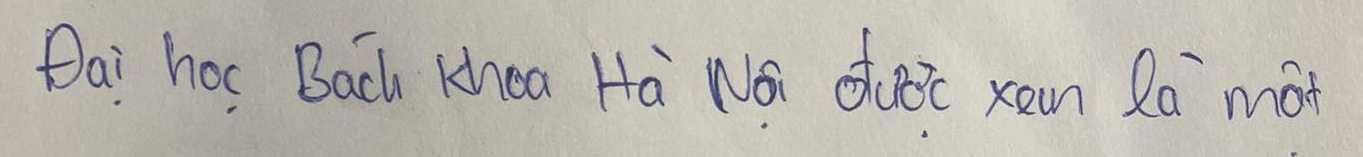

['Đại học Bách Khoa Hà Nội được xem là một']


In [39]:
img = Image.open("/mnt/disk4/VN_HTR/VN_HTR/test/test3_test2.jpg")
display(img)
preds, tokens, probs = infer_topk(processor(img, return_tensors="pt").pixel_values, model, 50)
print(tokenizer.batch_decode(preds, skip_special_tokens=True))

In [40]:
for i in range(10):
    print(dict(zip(tokenizer.batch_decode(tokens[:, i:i+1], skip_special_tokens=False), probs[:, i])))

{'Đại': 0.68705803, 'học': 0.9521056, 'B': 0.6039661, 'ách': 0.94180995, 'Khoa': 0.5026233, 'Hà': 0.84573597, 'Nội': 0.890768, 'được': 0.88352466, 'xem': 0.1840645, 'là': 0.9232243, 'một': 0.94633985, '</s>': 0.89155406}
{'Đặc': 0.06476989, 'mọc': 6.1038736e-05, 'Bán': 0.11187752, 'át': 0.014033836, 'khoa': 0.35554218, ',': 0.0048132064, 'Hội': 9.8074685e-05, 'trước': 0.0005007885, 'ven': 0.101919435, 'hà': 0.00040555152, 'mật': 0.00027163673, '.': 0.0018544872}
{'Độ': 0.004061517, 'hội': 5.987664e-05, 'S': 0.006508005, 'án': 0.001819493, 'Kha': 0.004125862, '<unk>': 0.0009541789, 'Lợi': 5.497783e-05, 'đường': 0.00030023925, 'sen': 0.077522315, 'lạ': 0.00039435754, 'mô': 0.00014585705, ',': 0.0003685144}
{'Đ': 0.0038898343, 'mạc': 5.7497746e-05, 'Bình': 0.00365835, 'ành': 0.0016279628, 'khai': 0.0035491711, '.': 0.0006845586, 'Ngô': 5.4424963e-05, 'đưa': 0.00012187454, 'xen': 0.032324433, 'Là': 0.00038757475, 'ột': 0.00012967945, ':': 0.00016032292}
{'Đà': 0.0027661794, '<unk>': 4.6699

IndexError: index 5 is out of bounds for axis 1 with size 5

In [ ]:
import os
for fn in ["wild_0_0.jpg", "wild_19_1107.jpg", "wild_19_1138.jpg", "wild_0_1.jpg", "wild_1_1.jpg", "wild_2_1.jpg"]:
    img = Image.open("/mnt/disk4/VN_HTR/VN_HTR/WildLine/" + fn)
    display(img)
    preds = infer(processor(img, return_tensors="pt").pixel_values, model, 50)
    print(tokenizer.batch_decode(preds, skip_special_tokens=True))